# **Monet Painting**


### Artists are recognized by their unique styles, including color choices and brush strokes. With advancements in Generative Adversarial Networks (GANs), we can now recreate such styles using machine learning.

### In this challenge, the goal is to develop a GAN that generates 7,000 to 10,000 Monet-style images. The GAN consists of:

###    **Generator** – Creates Monet-style images.
###    **Discriminator** – Distinguishes between real Monet paintings and generated images.

### The two networks compete: the generator tries to fool the discriminator, while the discriminator learns to detect fakes. The ultimate challenge is to generate realistic Monet-style images that can trick a classifier into believing they are authentic.


##
## **Import Libraries**

In [1]:
#  File Handling
import os
import re
import io
import zipfile

#Opening, processing, and saving images
from PIL import Image
import shutil

# Data manipulation & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Deep learning & GAN implementation
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Displaying progress bars for training loops
from tqdm import tqdm

## 
## **Hyperparameters**

In [2]:
EPOCHS = 100
BATCH_SIZE = 4
IMAGE_SIZE = 256
LR = 0.00005
BETA1 = 0.5
BETA2 = 0.999
NUM_PICKS = 7050

## 
## **Data Loading and Inspection**

In [3]:
PATH = '/kaggle/input/gan-getting-started/'

monet_files = os.listdir(PATH + 'monet_jpg')
photo_files = os.listdir(PATH + 'photo_jpg')

n_monet_files = len(monet_files)
n_photo_files = len(photo_files)

print(f"Count Monet pictures: {n_monet_files}")
print(f"Count Photos: {n_photo_files}")

Count Monet pictures: 300
Count Photos: 7038


## 
## **Device selection**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## 
## **Custom Image Dataset**

### This code block creates a custom CustomImageDataset class, which inherits from torch.utils.data.Dataset. 
### It is used to load images from the specified directory (img_dir) and pre-process them using transforms.

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


## 
## **Image Transformations**

### This code block defines the preprocessing of images before they are passed to the neural network. It uses transforms.Compose, which combines several transform operations.

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

##
## **Dataset Creation**

### This code block creates dataset objects for Monet images (Monet) and photos (Photo) using the CustomImageDataset custom class.

In [7]:
dataset_monet = CustomImageDataset(img_dir=PATH + "monet_jpg", transform=transform)
dataset_photo = CustomImageDataset(img_dir=PATH + "photo_jpg", transform=transform)

## 
## **DataLoader Creation**

In [8]:
dataloader_monet = DataLoader(dataset_monet, batch_size=BATCH_SIZE, shuffle=True)
dataloader_photo = DataLoader(dataset_photo, batch_size=BATCH_SIZE, shuffle=True)

## 
## **Check images shape**

In [9]:
for real_images in dataloader_monet:
    print("Real image batch shape:", real_images.shape)
    break 

for fake_images in dataloader_photo:
    print("Fake image batch shape:", fake_images.shape)
    break

Real image batch shape: torch.Size([4, 3, 256, 256])
Fake image batch shape: torch.Size([4, 3, 256, 256])


## 
## **Check files**

In [10]:
print(f"List of files in 'monet_jpg': {monet_files[:10]}")
print(f"List of files in 'photo_jpg': {photo_files[:10]}")

List of files in 'monet_jpg': ['f4413e97bd.jpg', '7341d96c1d.jpg', 'de6f71b00f.jpg', '99d94af5dd.jpg', '99a51d3e25.jpg', 'd05cab011d.jpg', '4e05523825.jpg', 'c68c52e8fc.jpg', '40d7d18ad3.jpg', 'f96a8de9f3.jpg']
List of files in 'photo_jpg': ['fb97febc5f.jpg', 'c54c5368af.jpg', '4a06596662.jpg', '2629524a69.jpg', '5e64b64de8.jpg', 'ed34d8d7f3.jpg', '8eaf38146d.jpg', '21c2c68337.jpg', '74e1d0f495.jpg', '1b98321823.jpg']


## 
## **Images visualisation**

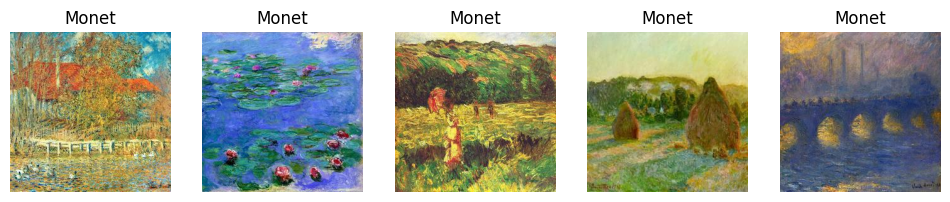

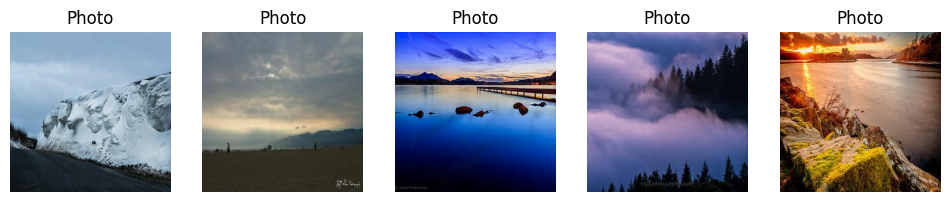

In [11]:
def show_images(images, labels, n_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

sample_monet = [Image.open(PATH + 'monet_jpg/' + img) for img in np.random.choice(monet_files, 5)]
sample_photo = [Image.open(PATH + 'photo_jpg/' + img) for img in np.random.choice(photo_files, 5)]

show_images(sample_monet, ['Monet'] * 5)
show_images(sample_photo, ['Photo'] * 5)

##
## **Model creation**

### 
### ResNet blocks in neural networks allow models to utilize layers more efficiently by passing information through additional paths (skip connections). 
### This makes learning more stable and allows models to achieve better results even if their architecture is very deep.

In [12]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(dim),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(dim),
            nn.Dropout(0.5)  
        )

        self.skip = nn.Conv2d(dim, dim, kernel_size=1, stride=1)

    def forward(self, x):
        return self.skip(x) + self.block(x)

## 
## **Generator**

### 
### The generator takes an image or noise as input (e.g. random values or an image to be stylized).
### It passes this through several convolutional and transposed convolutional layers to transform the input data into an image similar to the desired image (e.g. an artist's style).
### The model is trained using GAN, where the generator tries to “trick” the discriminator into producing more realistic images, while the discriminator learns to distinguish between real images and generated images.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, num_resnet_blocks=9):
        super(Generator, self).__init__()

        self.model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        ]

        # More ResNet blocks
        self.model += [ResnetBlock(256) for _ in range(num_resnet_blocks)]

        # Upsampling
        self.model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, output_nc, kernel_size=7, padding=3),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

## 
## **Discriminator**

### 
### The discriminator tries to distinguish real images (from the dataset) from the generated images (which come from the generator).
### In the learning process, the generator and discriminator compete with each other: the generator tries to fool the discriminator, and the discriminator tries to correctly classify images.

In [14]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

## 
## **Create Generators and Discriminators**

### 
### G_AB Generator: Converts images from Monet style to Photo style. For example, if you feed a Monet-style image to the input of this generator, it will try to return an image that looks like a normal photo.
### G_BA generator: Does the reverse conversion - from Photo to Monet. It takes a normal photo and generates a Monet-style image.
### Discriminator D_A: Evaluates whether the Monet-style image is real or generated.
### Discriminator D_B: Will evaluate whether the image of a normal photo is real or generated.

In [15]:
G_AB = Generator(3, 3).to(device)  # Monet → Photo
G_BA = Generator(3, 3).to(device)  # Photo → Monet
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

## 
## **Loss functions**

### criterion_GAN - used to train discriminators to be able to distinguish between real and generated images.
### criterion_cycle - used to train generators so that they can recover the original images after a conversion cycle.
### criterion_identity - also used for generators to keep the identity of images that already belong to the target domain.

In [16]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## 
## **Optimizers**

### 
### **optimizer_G** - trains the generators to produce images that can fool the discriminators.
### **optimizer_D_A and optimizer_D_B** - trains the discriminators so that they can accurately distinguish between real and generated images in their respective domains (photo and Monet style).

### Each of these optimizers is used to minimize their respective loss functions, which ultimately results in better image generation and improved ability of the discriminators to distinguish between real and generated images.

In [17]:
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=LR, betas=(BETA1, BETA2))

## **Train The GAN Model**

### This code trains the CycleGAN model to translate between photographs and Monet-style images. To do so, it alternates between training generators (to create convincing images) and discriminators (to distinguish between real and generated images).
### The main losses in doing so are as follows:
### **GAN loss:** Encourages the generators to fool the discriminators.
### **Loss of loop consistency:** Ensures that the images are translated back and forth correctly.
### **Identity loss:** Helps to maintain the identity of the features for both generators.

In [18]:
loss_D_A = None
loss_D_B = None
loss_G = None

for epoch in range(EPOCHS):
    for i, (real_A, real_B) in enumerate(zip(dataloader_photo, dataloader_monet)):
        batch_size = real_A.size(0)
        if batch_size < BATCH_SIZE:
            continue 

        real_A, real_B = real_A.to(device), real_B.to(device)

        valid = torch.ones_like(D_A(real_A)).to(device)
        fake = torch.zeros_like(D_A(real_A)).to(device)

        # Generators train
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        loss_identity_A = criterion_identity(G_BA(real_A), real_A)
        loss_identity_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_identity_A + loss_identity_B) * 5.0

        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = loss_GAN_AB + loss_GAN_BA

        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        loss_G = loss_identity + loss_GAN + loss_cycle
        loss_G.backward()
        optimizer_G.step()

       
        if epoch > 5:
            optimizer_D_A.zero_grad()
            loss_real_A = criterion_GAN(D_A(real_A), valid)
            loss_fake_A = criterion_GAN(D_A(fake_A.detach()), fake)
            loss_D_A = (loss_real_A + loss_fake_A) / 2
            loss_D_A.backward()
            optimizer_D_A.step()

            optimizer_D_B.zero_grad()
            loss_real_B = criterion_GAN(D_B(real_B), valid)
            loss_fake_B = criterion_GAN(D_B(fake_B.detach()), fake)
            loss_D_B = (loss_real_B + loss_fake_B) / 2
            loss_D_B.backward()
            optimizer_D_B.step()

    if epoch > 5 and epoch%5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], loss_D_A: {loss_D_A.item()}, loss_D_B: {loss_D_B.item()}, loss_G: {loss_G.item()}")

Epoch [11/100], loss_D_A: 0.14054152369499207, loss_D_B: 0.18676891922950745, loss_G: 8.35936450958252
Epoch [16/100], loss_D_A: 0.16302378475666046, loss_D_B: 0.14387811720371246, loss_G: 7.592739105224609
Epoch [21/100], loss_D_A: 0.2232740968465805, loss_D_B: 0.18529516458511353, loss_G: 6.627204895019531
Epoch [26/100], loss_D_A: 0.20546400547027588, loss_D_B: 0.13408593833446503, loss_G: 7.248295783996582
Epoch [31/100], loss_D_A: 0.1118362545967102, loss_D_B: 0.17773005366325378, loss_G: 6.063600540161133
Epoch [36/100], loss_D_A: 0.198670893907547, loss_D_B: 0.11904111504554749, loss_G: 6.2525434494018555
Epoch [41/100], loss_D_A: 0.23144948482513428, loss_D_B: 0.22317779064178467, loss_G: 5.635953903198242
Epoch [46/100], loss_D_A: 0.12043533474206924, loss_D_B: 0.11655154824256897, loss_G: 5.683961868286133
Epoch [51/100], loss_D_A: 0.13516467809677124, loss_D_B: 0.1697075068950653, loss_G: 5.608096122741699
Epoch [56/100], loss_D_A: 0.17253567278385162, loss_D_B: 0.0789340138

## **Generate Image**

### Here I am extracting a single image from the dataset, passes it through the generator G_BA to generate a Monet-style image, normalizes the result, and visualizes it using matplotlib

torch.Size([1, 3, 256, 256])
Input shape before generator: torch.Size([1, 3, 256, 256])


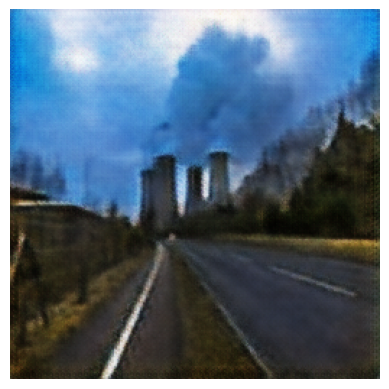

In [19]:
input_image = None

for i, (real_images) in enumerate(dataloader_photo):
    if i == 0:
        input_image = real_images[0].unsqueeze(0).to(device) 
        break

print(input_image.size())

print("Input shape before generator:", input_image.shape) 

with torch.no_grad():  
    generated_image = G_BA(input_image)

generated_image = generated_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_image = (generated_image + 1) / 2 
generated_image = generated_image.clip(0, 1) 

plt.imshow(generated_image)
plt.axis("off")
plt.show()

## 
## **Save Images in ZIP file**

In [20]:
def generate_and_save_images(generator, dataloader_photo, num_images=8000, output_folder="/kaggle/working/images", device="cuda"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    generator.to(device)
    generator.eval()

    image_count = 0
    with torch.no_grad():
        for real_images in tqdm(dataloader_photo, desc="Generating Images"):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            if image_count >= num_images:
                break 
            
            generated_images = generator(real_images) 
            
            for i in range(batch_size):
                if image_count >= num_images:
                    break

                
                generated_image = generated_images[i].cpu().permute(1, 2, 0).numpy()
                generated_image = (generated_image + 1) * 127.5 
                generated_image = np.clip(generated_image, 0, 255).astype(np.uint8)

                img = Image.fromarray(generated_image)
                img.save(f"{output_folder}/monet_image_{image_count+1}.jpg")

                image_count += 1

    shutil.make_archive("/kaggle/working/images", 'zip', output_folder)
    print(f"Saved and zipped {num_images} images in /kaggle/working/images.zip")

In [21]:
generate_and_save_images(G_BA, dataloader_photo, num_images=NUM_PICKS, output_folder="/kaggle/working/images", device=device) 

Generating Images: 100%|██████████| 1760/1760 [02:39<00:00, 11.06it/s]


Saved and zipped 7050 images in /kaggle/working/images.zip


## 
## **Conclusion**

### **Objective:** I worked on a project in which we used generative adversarial networks (GANs) to transform ordinary photographs into the style of Claude Monet paintings. The goal was to train a model to produce images stylized to look like Monet's paintings using two types of networks: a generator and a discriminator.

### **Data preprocessing:**
### **Data loading and preparation:** The data was obtained from a set containing photographs and Monet paintings. The os, PIL, and torchvision libraries were used to load and preprocess the images.
### **Image preprocessing:** Images were resized to 256x256 pixels and normalized using standard values for RGB channels (mean 0.5 and standard deviation 0.5).
### **Use of custom Dataset and DataLoader:** We created custom classes for easy handling of images and used the DataLoader to efficiently feed data into the model.

### **GAN Model:**
### **Generator:** The generator model was built using ResNet blocks, which ensured the stability of the training and the quality of the generated images. The generator creates an image from a photograph by stylizing it to look like Monet paintings.
### **Discriminator:** The discriminator uses multiple convolutional layers to classify the image as real or generated, working on LS-GAN (Least Squares GAN) principle, where MSE loss function was used instead of BCE for more stable training.

### **Loss features:**
### GAN loss (MSE), cyclic consistency loss (L1 Loss), and identity loss to ensure that the generator not only transforms images but also preserves important characteristics of the original photos.

### **Optimization:**
### Adam optimizers were used for the generator and discriminators, with a small learning rate value (0.00005) and beta parameters (0.5 and 0.999) to ensure training stability.

### **Training results:**
### The training process lasted 100 epochs. After the first few epochs, the generator began to produce more expressive Monet-styled images. I observed that the generator and discriminator losses decreased as training progressed.

### **Overall conclusions:**
### The process of creating images in the style of artists such as Monet using GANs was successful and the model demonstrated the ability to mimic unique artistic styles.
### Utilizing the ResNet architecture for the generator helped improve image quality and accelerated learning.
### It was important to monitor the tuning of hyperparameters for stability of the process.

### **Future improvements:**
### **Data augmentation:** Additional data augmentation techniques could be applied to improve the generalizability of the model.
### **Tweaking:** The architecture may need to be further tuned to better reproduce the details of the picture, e.g., introducing attention or other techniques to improve image quality.